# xWines PCA TRL

This notebook tests how well PCA (principal components analysis) works for TRL (Table Representation Learning).

In [2]:
xwines_df = pd.read_csv("XWines_Slim_1K_wines.csv")
xwines_df.iloc[0]

WineID                                                   100001
WineName                                     Espumante Moscatel
Type                                                  Sparkling
Elaborate                                         Varietal/100%
Grapes                                       ['Muscat/Moscato']
Harmonize                    ['Pork', 'Rich Fish', 'Shellfish']
ABV                                                         7.5
Body                                              Medium-bodied
Acidity                                                    High
Code                                                         BR
Country                                                  Brazil
RegionID                                                   1001
RegionName                                         Serra Gaúcha
WineryID                                                  10001
WineryName                                          Casa Perini
Website                        http://ww

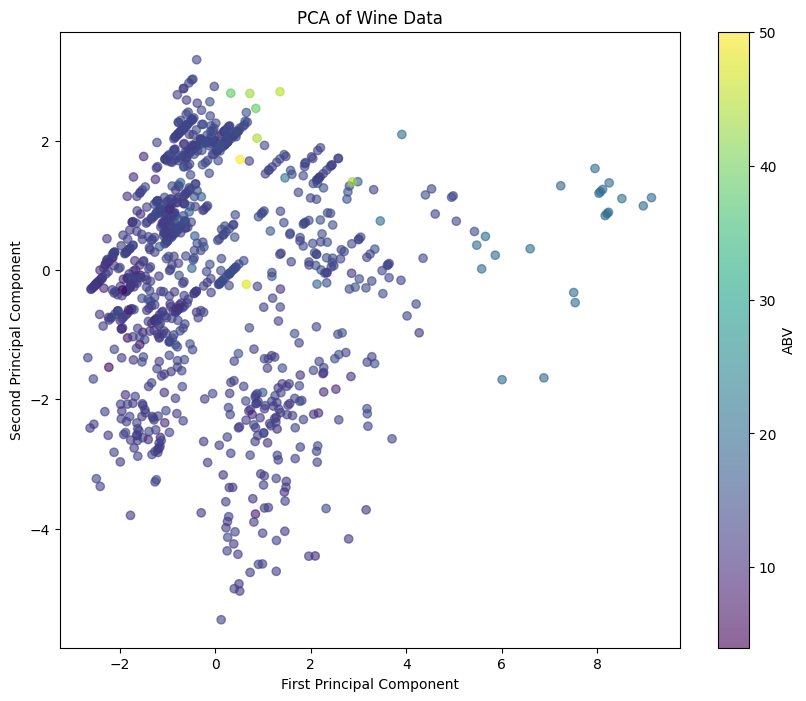

Explained variance ratio: [0.05551706 0.04464386]

Nearest neighbors for wine Espumante Moscatel:
- 33     Terranova Espumante Moscatel
28                         Moscatel
23                         Moscatel
622                     Merlot Rosé
24                    Origem Merlot
Name: WineName, dtype: object
- 0    Espumante Moscatel
0    Espumante Moscatel
0    Espumante Moscatel
0    Espumante Moscatel
0    Espumante Moscatel
Name: WineName, dtype: object


In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Function to encode list-like strings
def encode_list(x):
    if isinstance(x, str):
        return len(eval(x))
    return 0

# Prepare the features
features = []

# Numeric features
numeric_features = ['ABV']
features.extend(numeric_features)

# Categorical features for one-hot encoding
categorical_features = ['Type', 'Elaborate', 'Body', 'Acidity', 'Country']
features.extend(categorical_features)

# List-like features to encode as counts
list_features = ['Grapes', 'Harmonize', 'Vintages']
for feature in list_features:
    xwines_df[f'{feature}_count'] = xwines_df[feature].apply(encode_list)
    features.append(f'{feature}_count')

# Prepare the feature matrix
X = xwines_df[features]

# Handle missing values
imputer = SimpleImputer(strategy='constant', fill_value='missing')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = encoder.fit_transform(X_imputed[categorical_features])
categorical_columns = encoder.get_feature_names_out(categorical_features)

# Combine numeric and encoded categorical features
X_encoded = np.hstack([
    X_imputed[numeric_features].values,
    categorical_encoded,
    X_imputed[[f'{feature}_count' for feature in list_features]].values
])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=xwines_df['ABV'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='ABV')
plt.title('PCA of Wine Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Function to find nearest neighbors
def find_nearest_neighbors(query_index, X_pca, n_neighbors=5):
    similarities = cosine_similarity([X_pca[query_index]], X_pca)[0]
    nearest_indices = np.argsort(similarities)[::-1][1:n_neighbors+1]  # Exclude the query wine itself
    return nearest_indices, similarities[nearest_indices]

# Example: Find nearest neighbors for the first wine
query_index = 0
nearest_indices = find_nearest_neighbors(query_index, X_pca)

print(f"\nNearest neighbors for wine {xwines_df.iloc[query_index]['WineName']}:")
for idx in nearest_indices:
    print(f"- {xwines_df.iloc[idx]['WineName']}")

In [17]:
ratings_df = pd.read_csv("XWines_Slim_150K_ratings.csv")
ratings_df.head(5)

/var/folders/41/8dp_379x15d8zz4ppsjthdw40000gn/T/ipykernel_10334/458111286.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv("XWines_Slim_150K_ratings.csv")


,RatingID,UserID,WineID,Vintage,Rating,Date
0,143,1356810,103471,1950,4.5,2021-11-02 20:52:59
1,199,1173759,111415,1951,5.0,2015-08-20 17:46:26
2,348,1164877,111395,1952,5.0,2020-11-13 05:40:26
3,374,1207665,111433,1953,5.0,2017-05-05 06:44:13
4,834,1075841,111431,1955,5.0,2016-09-14 20:18:38


In [26]:
ratings_per_wine = ratings_df['WineID'].value_counts()
average_ratings_per_wine = ratings_per_wine.mean()
median_ratings_per_wine = ratings_per_wine.median()

print(f"Average number of ratings per WineID: {average_ratings_per_wine:.2f}")
print(f"Median number of ratings per WineID: {median_ratings_per_wine:.2f}")

Average number of ratings per WineID: 148.96
Median number of ratings per WineID: 53.00


## Test Methodology

Similar wines should have similar ratings

How aligned is the average rating of the top K nearest neighbors computed with the PCA representation to the ground truth rating?

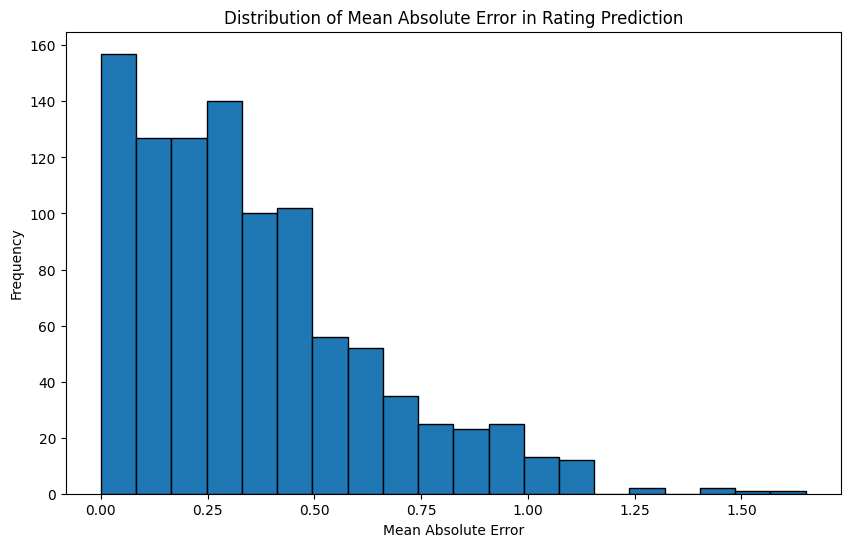

Mean MAE: 0.3568
Median MAE: 0.3004
Standard deviation: 0.2771


In [23]:
def get_average_rating(wine_id):
    wine_ratings = ratings_df[ratings_df['WineID'] == wine_id]['Rating']
    return wine_ratings.mean() if len(wine_ratings) > 0 else None

def test_rating_prediction(n_samples=100, n_neighbors=5):
    mae_scores = []
    for _ in range(n_samples):
        query_index = np.random.choice(len(xwines_df))
        query_wine_id = xwines_df.iloc[query_index]['WineID']
        query_rating = get_average_rating(query_wine_id)
        
        if query_rating is None:
            continue
        
        nearest_indices, similarities = find_nearest_neighbors(query_index, X_pca, n_neighbors)
        
        neighbor_ratings = []
        for idx in nearest_indices:
            neighbor_id = xwines_df.iloc[idx]['WineID']
            neighbor_rating = get_average_rating(neighbor_id)
            if neighbor_rating is not None:
                neighbor_ratings.append(neighbor_rating)
        
        if len(neighbor_ratings) > 0:
            predicted_rating = np.mean(neighbor_ratings)
            mae = abs(predicted_rating - query_rating)
            mae_scores.append(mae)
    
    return mae_scores

# Run the rating prediction test
mae_scores = test_rating_prediction(n_samples=1_000, n_neighbors=3)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.hist(mae_scores, bins=20, edgecolor='black')
plt.title('Distribution of Mean Absolute Error in Rating Prediction')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
print(f"Mean MAE: {np.mean(mae_scores):.4f}")
print(f"Median MAE: {np.median(mae_scores):.4f}")
print(f"Standard deviation: {np.std(mae_scores):.4f}")